In [2]:
from os import listdir
from os.path import isfile
from fnmatch import fnmatch
from math import isnan, ceil
from pprint import pprint
from statistics import median
from re import match, search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def get_ratio(filename):
    return filename.split('_')[0].replace('ratio','')

In [4]:
def get_run(filename):
    return int(filename.split('_')[1].replace('run',''))

In [5]:
def get_vcs(filename):
    return int(filename.split('_')[2].replace('vclients',''))

In [6]:
def get_client(filename):
    return int(filename.split('_')[3].replace('client', ''))

In [7]:
def get_instance(filename):
    return int(filename.split('_')[-1].replace('instance','').replace('.log', ''))

In [8]:
def roundup(x):
    return int(ceil(x / 1.0)) * 1

In [9]:
def parse_line(line):
    ops_pat = '(\d+) \(avg:\s+\d+\) ops/sec,'
    ops = int(search(ops_pat, line).group(1))
    latency_pat = '(\d+\.\d+) \(avg:\s+\d+\.\d+\) msec latency'
    latency = float(search(latency_pat, line).group(1))
    return {'ops': ops, 'rt': latency}

In [10]:
def parse_content(path, filename):
    content = []
    with (open(path+filename, 'r')) as file:
        for line in file.readlines():
            if line.startswith('[RUN #1 ') and 'nan' not in line:
                content.append(parse_line(line))
    return content[10:60]

In [11]:
def dump_csv(df, filename):
    df.to_csv(filename, float_format='%.2f')
    return

In [12]:
def get_avg_rt(df, ratios, vclients, runs, threads, instances, clients):
    rts = []
    stds = []
    ils = []
    xs = [x * threads * instances * clients for x in vclients] 
    for ratio in ratios:
        values = [.0] * len(vclients)
        std = [.0] * len(vclients)
        il = [.0] * len(vclients)
        fig, ax = plt.subplots()
        for i, vc in enumerate(vclients):
            values[i] = df.unstack().loc[(ratio, vc), 'ResponseTime (ms)'].T.mean().unstack().T.mean().mean()
            std[i] = np.std(df.unstack().loc[(ratio, vc), 'ResponseTime (ms)'].T.mean().unstack().T.mean().mean())
            il[i] = 1000 / values[i] * (vc * threads * instances * clients)
        plt.errorbar(xs , values, std, label='AVG of %d reps[stdev]' % max(runs), capsize=3)
        ax.set_xlim(xmin=0, xmax=max(xs))
        plt.ylim(0, int(max(values) + 0.3*int((max(values)))))
        plt.xticks(xs)
        plt.xlabel('Virtual Clients')
        plt.ylabel('Response Time (msec)')
        plt.legend(loc='lower right', frameon=False)
        plt.grid(b=True, which='major', axis='both', color='0.6', linestyle='dotted')
        rts.append(values)    
        stds.append(std)
        ils.append(il)
        title = 'MEMTIER'
        if ratio == '1:0':
            op = 'write-only'
        else:
            op = 'read-only'
        filename = ('rt_%s_%s' % (title, '_'.join(op.split('-')))).lower()
        plt.savefig('img/%s.pdf' % filename, bbox_inches='tight')
    return rts, stds, ils

In [13]:
def get_avg_tp(df, ratios, vclients, runs, ils, threads, instances, clients):
    tps = []
    stds = []
    xs = [x * threads * instances * clients for x in vclients] 
    for j, ratio in enumerate(ratios):
        values = [.0] * len(vclients)
        std = [.0] * len(vclients)
        fig, ax = plt.subplots()
        for i, vc in enumerate(vclients):
            values[i] = df.unstack().loc[(ratio, vc), 'Throughput (ops/s)'].T.sum().unstack().T.sum().mean()
            std[i] = np.std(df.unstack().loc[(ratio, vc), 'Throughput (ops/s)'].T.sum().unstack().T.sum())
        plt.errorbar(xs, values, std, label='AVG of %d reps[stdev]' % max(runs), capsize=3)
        plt.plot(xs, ils[j], label='Interactive Law', linestyle='dotted')
        ax.set_xlim(xmin=0, xmax=max(xs))
        plt.ylim(0, int(max(values) + 0.05*(max(values))))
        plt.xticks(xs)
        plt.xlabel('Virtual Clients')
        plt.ylabel('Throughput (Ops/sec)')
        plt.legend(loc='lower right', frameon=False)
        plt.grid(b=True, which='major', axis='both', color='0.6', linestyle='dotted')
        k_formatter = lambda v, p: str(float(v / 1000)) + 'k'
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))
        tps.append(values)
        stds.append(std)
        title = 'MEMTIER'
        if ratio == '1:0':
            op = 'write-only'
        else:
            op = 'read-only'
        filename = ('tp_%s_%s' % (title, '_'.join(op.split('-')))).lower()
        plt.savefig('img/%s.pdf' % filename, bbox_inches='tight')
    return tps, stds

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[2, 8, 16, 32, 48, 64]
[2, 8, 16, 32, 48, 64]


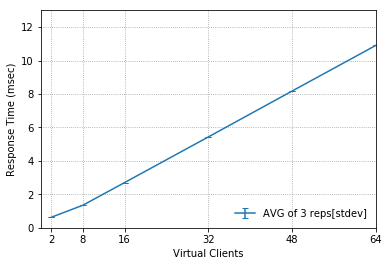

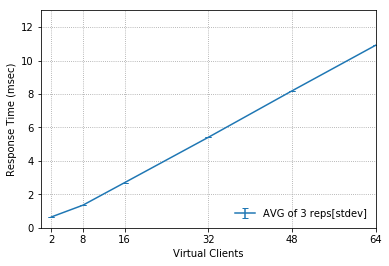

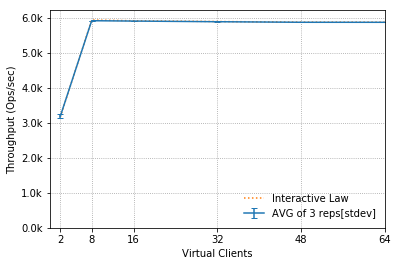

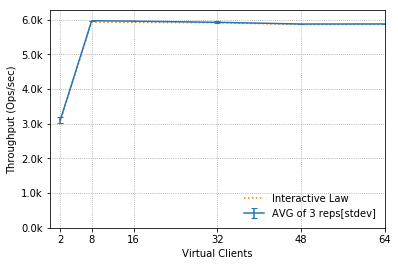

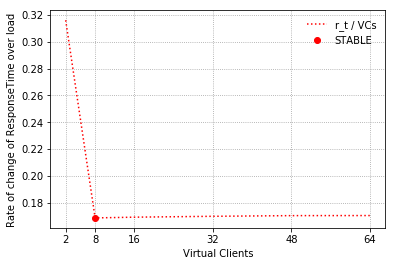

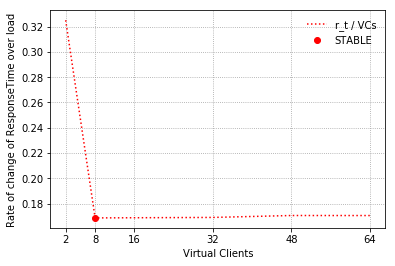

In [20]:
timestamp = '20181024141555'
log_dir = 'logs/%s/' % timestamp

logs = [f for f in listdir(log_dir) if fnmatch(f, '*.log')]

ratios = ['0:1', '1:0']
runs = [x for x in range(1, 3 + 1)] 
instances = [x for x in range(1, 2 + 1)]
threads = 1 
clients = [x for x in range(1, 1 + 1)]
vclients = [1, 4, 8, 16, 24, 32]

multi_index = [ratios, vclients, runs, clients, instances]
len_index = len(ratios) * len(vclients) * len(runs) * len(clients) * len(instances)

index = pd.MultiIndex.from_product(multi_index, names=['ratio', 'VCs', 'run', 'client', 'instance'])
columns = ['Throughput (ops/s)', 'ResponseTime (ms)']
pd.options.display.float_format = '{0:.2f}'.format 
template = pd.DataFrame([[.0] * len(columns)] * len_index, index=index, columns=columns)

for log_file in logs: 

    ratio = get_ratio(log_file) 
    run = get_run(log_file)
    vcs = get_vcs(log_file)
    client = get_client(log_file)
    instance = get_instance(log_file)
    
    content = parse_content(log_dir, log_file)
    
    avg_tp = sum(d['ops'] for d in content) / len(content)
    avg_rt = sum(d['rt'] for d in content) / len(content)
   
    template.loc[(ratio, vcs, run, client, instance), 'Throughput (ops/s)'] = avg_tp
    template.loc[(ratio, vcs, run, client, instance), 'ResponseTime (ms)'] = avg_rt
    
    
rts, stds, ils = get_avg_rt(template, ratios, vclients, runs, threads, len(instances), len(clients))
tps, stds = get_avg_tp(template, ratios, vclients, runs, ils, threads, len(instances), len(clients))

dump_csv(template, 'out/memtier_data.csv')

for i, ratio in enumerate(ratios):
    fig, ax = plt.subplots()
    xs = vclients 
    xs = [x * threads * len(instances) * len(clients) for x in xs]
    print(xs)
    values = rts[i]
    plt.xticks(xs)
    plt.xlabel('Virtual Clients')
    plt.ylabel('Rate of change of ResponseTime over load')
    plt.legend(loc='lower right', frameon=False)
    plt.grid(b=True, which='major', axis='both', color='0.6', linestyle='dotted')
    plt.plot(xs, [(values[x]) / xs[x] for x in range(len(xs))], color='r', linestyle='dotted', label='r_t / VCs')
    plt.plot(xs[1], [(values[1]) / xs [1]], 'o', color='r', label='STABLE')
    plt.legend(loc='best', frameon=False)
    title = 'MEMTIER'
    if ratio == '1:0':
        op = 'write-only'
    else:
        op = 'read-only'
    filename = ('maxtp_%s_%s' % (title, '_'.join(op.split('-')))).lower()
    plt.savefig('img/%s.pdf' % filename, bbox_inches='tight')